# intermediate time series forecasting

- dynamic (harmonic) regression model, e.g. SARIMAX — linear regression with SARIMA errors plus Fourier terms for long/complex seasonality)

In [1]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import sklearn.model_selection
import statsmodels.api as sm
import statsmodels.tsa

import data_dives
from data_dives import time_series_forecasting as tsf

In [2]:
# set some default plot params
plt.rcParams.update(
    {
        "figure.figsize": (16, 6),
        "figure.facecolor": "white",
        "axes.labelsize": "x-large",
        "legend.fontsize": "x-large",
        "legend.frameon": False,
        "lines.linewidth": 2,
    }
)

## problem definition

Air pollution is a chronic problem in many large cities. It's harmful to inhabitants' health, and is estimated to kill millions of people prematurely every year [[source](https://www.who.int/mediacentre/news/releases/2014/air-pollution/en/)]; it's also harmful to the environment. We would like to forecast air pollution levels up to a few days in advance so that individuals can prepare accordingly, similar to a weather forecast.

## information gathering

"Air pollution" encompasses a variety of harmful pollutants produced by both natural and anthropogenic sources, indoors and outdoors; it includes ground-level ozone ("smog"), particulate matter (PM aka "soot"), nitrogen oxides, sulfur dioxide, carbon monoxide, and even pollen. Recent research has shown that fine particulate matter, particularly PM2.5 (airborne particles of size <2.5μm), has significant, negative affects on health and climate [[source](https://www.epa.gov/pm-pollution/health-and-environmental-effects-particulate-matter-pm)]. Causes of air pollution include fossil fuel-based electricity generation, automobile exhaust, industrial processes, volcanos, and wildfires — among others [[source](https://www.britannica.com/science/air-pollution#ref286153)].

Since air pollution consists of many components, has many sources, and is highly variable in both time and space, we should probably start by focusing on a particular pollutant in a particular city; given the degree of harm, let's go with PM2.5 levels in a large city with notably bad air quality.

The gold standard of PM2.5 measurement is via ground-level monitoring stations in hundreds of locations worldwide. It can also be measured by combining satellite observations of airborne particulates with physical models of the atmosphere, but there are limitations to this methodology [[source](https://www.worldbank.org/en/news/feature/2015/07/14/understanding-air-pollution-and-the-way-it-is-measured)]. PM2.5 concentrations are notably affected by — and affect — local atmospheric conditions, such as wind and rain. According to EPA standards, low ("safe") PM2.5 concentrations are $\leq 35\mu g / m^{3}$ [[source](https://www.epa.gov/particle-pollution-designations/particle-pollution-designations-guidance-and-data)].

### dataset acquisition

The EPA provides [air quality data](https://www.epa.gov/air-trends/air-quality-cities-and-counties) at the city/county level, which is good, but only at an annual cadence, which is not good enough for localized day-to-day forecasts. They also have a more customizable but cumbersome access point [here](https://www.epa.gov/outdoor-air-quality-data/download-daily-data), but the daily data seems to be reported only once every couple or few days. Still not good enough. The CDC has [PM2.5 concentrations data](https://data.cdc.gov/Environmental-Health-Toxicology/Daily-Census-Tract-Level-PM2-5-Concentrations-2011/fcqm-xrf4) at daily resolution for several years, but at the spatial resolution of census tracts, which is _okay_. Any other options?

By chance, I found a dataset containing PM2.5 concentrations and local weather conditions in Beijing, China at hourly resolution over several years, alongside a paper: ["Assessing Beijing's PM2.5 pollution: severity, weather impact, APEC and winter heating"](https://royalsocietypublishing.org/doi/10.1098/rspa.2015.0257). _Perfect_. There will be some conceptual and methodological overlap between the work here and that covered in the paper, but if we can manage to reproduce some peer reviewed science, then all the better for this tutorial!

In [3]:
dataset = data_dives.datasets.BeijingPM25()
dataset.info

{'name': 'Beijing PM2.5',
 'site_url': 'https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data',
 'description': 'Particulate matter of size 2.5µm or less (PM2.5) measurements made by the US Embassy in Beijing, as well as meteorological data from Beijing Capital International Airport. Hourly resolution, from 2010-01-01 to 2014-12-31.',
 'citation': "Liang, X., Zou, T., Guo, B., Li, S., Zhang, H., Zhang, S., Huang, H. and Chen, S. X. (2015). Assessing Beijing's PM2.5 pollution: severity, weather impact, APEC and winter heating. Proceedings of the Royal Society A, 471, 20150257.",
 'download_url': 'https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv'}

In [4]:
raw_data = dataset.load()
raw_data

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


### dataset preparation

Since we only aim to forecast at daily resolution, let's resample our hourly data to match.

- combine separate datetime component columns, and set as index
- take the mean of resampled hourly observations, with special handling for the wind variables:
    - for categorical `wind_dir` column, take the mode
    - for `cum_wind_speed` column, which represents the cumulative wind speed in a particular direction, take the max value reached by the mode wind direction
- rename columns for clarity

In [5]:
data = dataset.prepare(raw_data, freq="1D", fill="forward")
data

,pm2.5,dew_point,temp,pressure,hrs_snow,hrs_rain,wind_dir,cum_wind_speed
dt,,,,,,,,
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,0.708333,0.0,SE,55.43
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,14.166667,0.0,SE,127.84
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,0.000000,0.0,NW,198.45
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,0.000000,0.0,NW,218.57
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,0.000000,0.0,NE,59.00
...,...,...,...,...,...,...,...,...
2014-12-27,238.666667,-9.666667,-1.791667,1027.833333,0.000000,0.0,NW,27.73
2014-12-28,197.375000,-10.791667,1.583333,1019.958333,0.000000,0.0,NW,37.98
2014-12-29,159.000000,-12.333333,0.750000,1013.750000,0.000000,0.0,cv,8.46


## exploratory data analysis

Just the usual set of descriptive statistics and visualizations required to understand the patterns and relationships in our dataset.

In [6]:
col_to_label = {
    "pm2.5": "PM2.5 (µg/m^3)",
    "dew_point": "dew point (ºC)",
    "temp": "temperature (ºC)",
    "pressure": "pressure (hPa)",
    "cum_wind_speed": "cum. wind speed (m/s)",
    "hrs_snow": "snow (hrs)",
    "hrs_rain": "rain (hrs)",
}

In [7]:
data.describe(include="number")

,pm2.5,dew_point,temp,pressure,hrs_snow,hrs_rain,cum_wind_speed
count,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000
mean,98.062770,1.828516,12.459041,1016.447306,0.052763,0.195023,56.490005
std,77.234246,14.163508,11.552997,10.076053,0.546072,0.993917,71.316689
min,2.958333,-33.333333,-14.458333,994.041667,0.000000,0.000000,1.340000
25%,41.727273,-10.083333,1.541667,1007.916667,0.000000,0.000000,17.430000
50%,78.913043,2.041667,13.916667,1016.208333,0.000000,0.000000,33.980000
75%,130.708333,15.083333,23.166667,1024.541667,0.000000,0.000000,62.130000
max,552.478261,26.208333,32.875000,1043.458333,14.166667,17.583333,585.600000


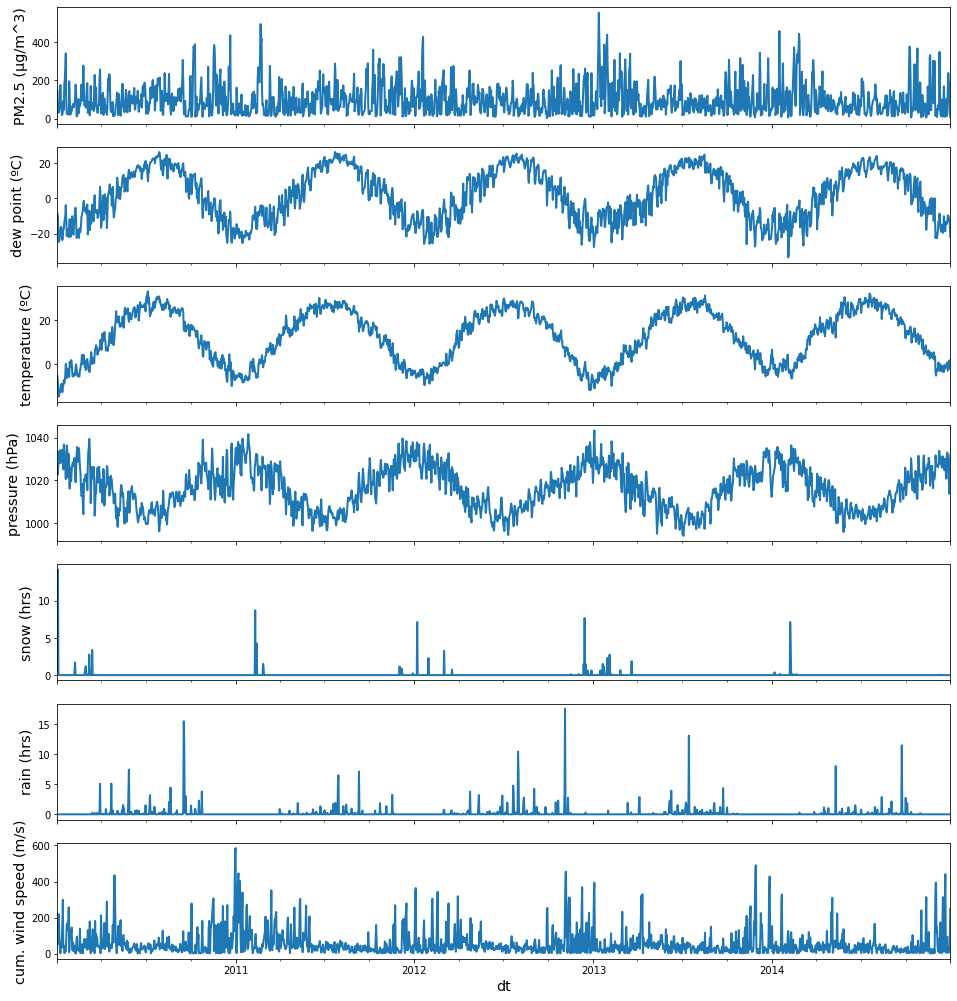

In [8]:
cols = data.select_dtypes(include="number").columns
_ = tsf.viz.plot_time_series(
    [data[col] for col in cols],
    labels=[col_to_label[col] for col in cols],
    figsize=(16, len(cols) * 2.5),
)

As expected of meteorological phenomena in a temperate zone, most of these variables have some degree of annual seasonality. Temperature is higher in summer and lower in winter; snow and rain trade off accordingly; cumulative wind speed seems lower and less variable during the summer; etc. PM2.5 concentration in micrograms per cubic meter — the forecast variable — is highly variable. (One wonders if this may be a more difficult forecasting task than anticipated...) If you squint, it looks as if there's some amount of annual seasonality; and given what we know about its causes, weekly seasonality may also be present.

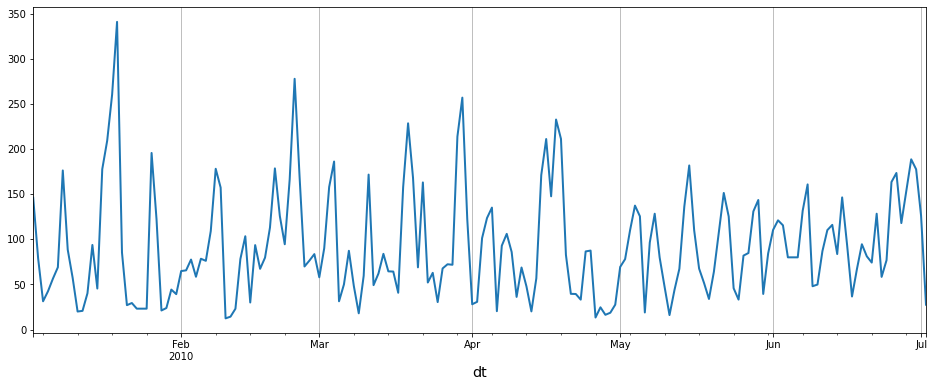

In [9]:
ax = data["pm2.5"].head(7 * 26).plot.line()
ax.grid(True, which="major", axis="x")

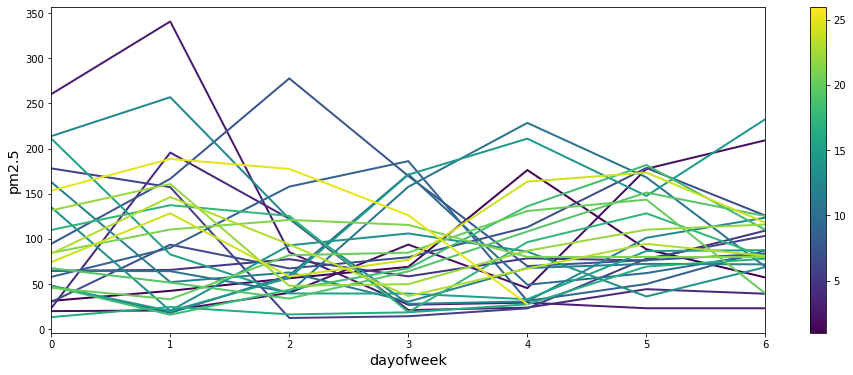

In [10]:
_ = tsf.viz.plot_seasonal_periods(data["pm2.5"].iloc[2: 7 * 26].groupby(by=data.index.isocalendar().week), "dayofweek")

I _might_ believe there's weekly seasonality in there, but the high variability means it's pretty weak. Well, we can sort seasonality out when modeling. In the meantime... How are these variables distributed, and how do they relate to each other, pairwise?

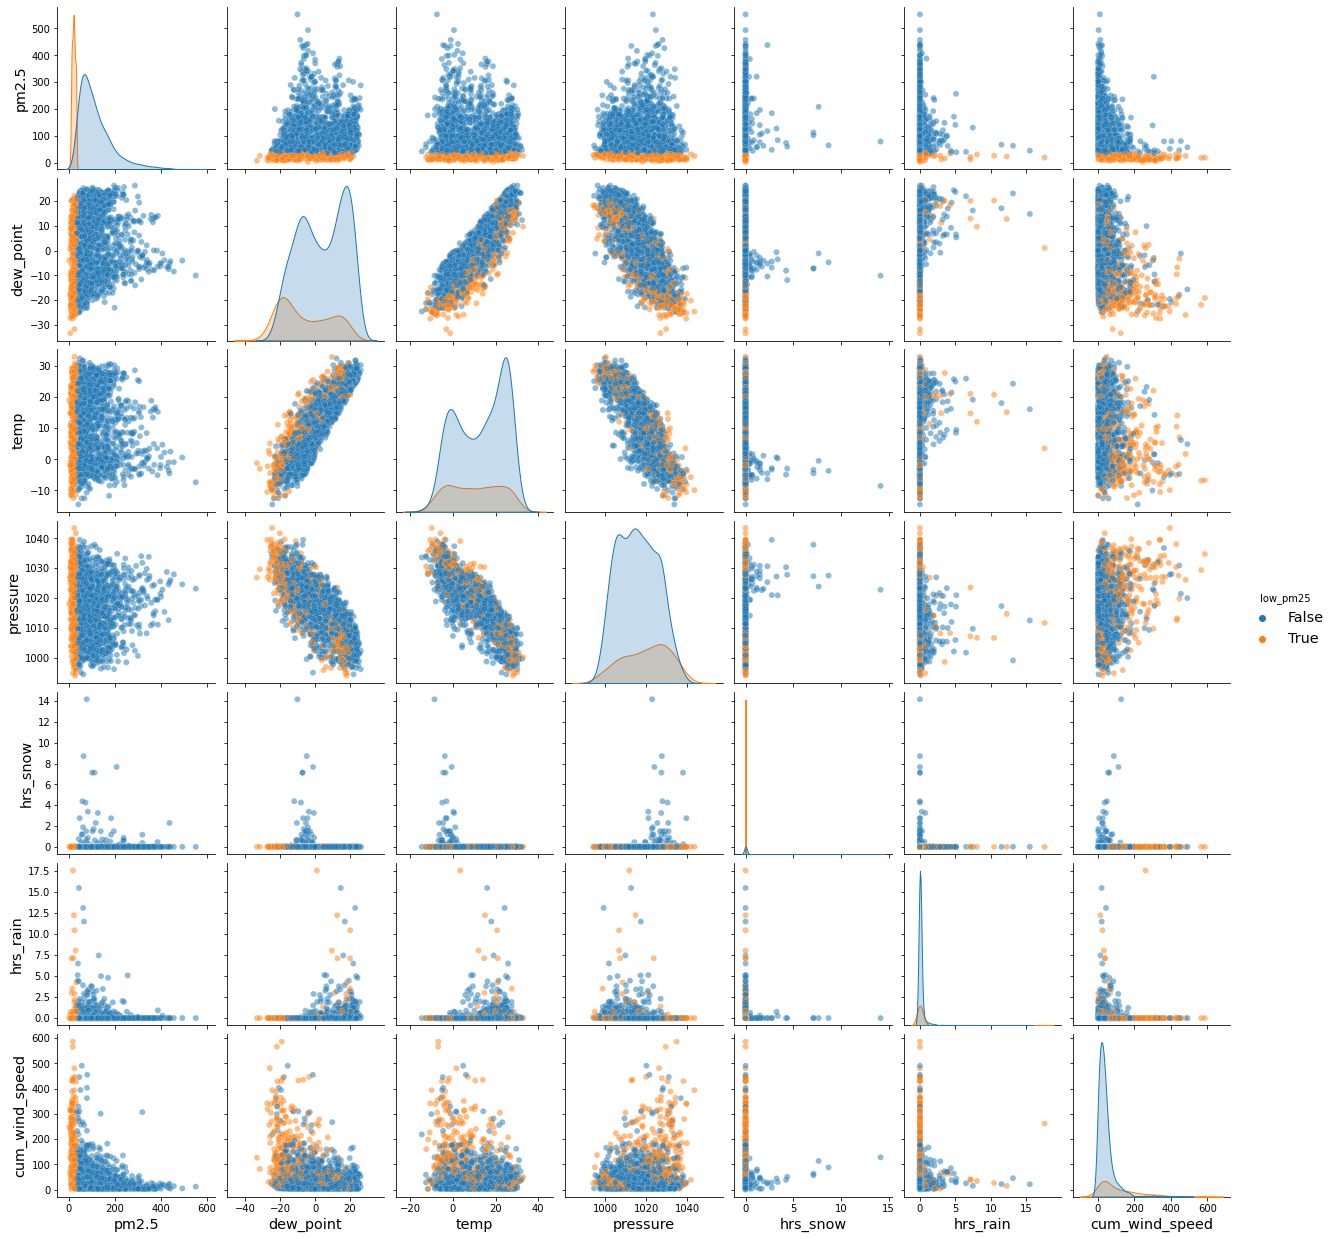

In [11]:
_ = sb.pairplot(
    data=data.assign(low_pm25=lambda df: df["pm2.5"] < 35),
    hue="low_pm25",
    plot_kws={"linewidth": 0.25, "alpha": 0.5},
)

In [12]:
data.corr(method="spearman")

,pm2.5,dew_point,temp,pressure,hrs_snow,hrs_rain,cum_wind_speed
pm2.5,1.000000,0.255002,0.023380,-0.124362,0.125666,0.081590,-0.389093
dew_point,0.255002,1.000000,0.903187,-0.806582,-0.108188,0.458748,-0.248317
temp,0.023380,0.903187,1.000000,-0.874445,-0.232211,0.319284,-0.071153
pressure,-0.124362,-0.806582,-0.874445,1.000000,0.196742,-0.346991,0.059586
hrs_snow,0.125666,-0.108188,-0.232211,0.196742,1.000000,-0.039406,0.004121
hrs_rain,0.081590,0.458748,0.319284,-0.346991,-0.039406,1.000000,-0.083390
cum_wind_speed,-0.389093,-0.248317,-0.071153,0.059586,0.004121,-0.083390,1.000000


We can see that PM2.5 is quite skewed, where many days have low or moderate values and some days have very high values. Wind speed and rain/snow hours are even more skewed toward low values. PM2.5 is positively correlated with dew point, negatively with pressure, and strongly negatively correlated with wind speed — since strong winds have a way of pushing local air pollution _away_. The other dependent variables' correlations are weak, but that doesn't necessarily mean that they won't provide a forecasting model with useful information in combination with the other variables. We can also see relationships between the dependent variables themselves, but none of the collinearity looks problematically strong.

Given the observed skew, we may prefer to model the log of the PM2.5 concentration:

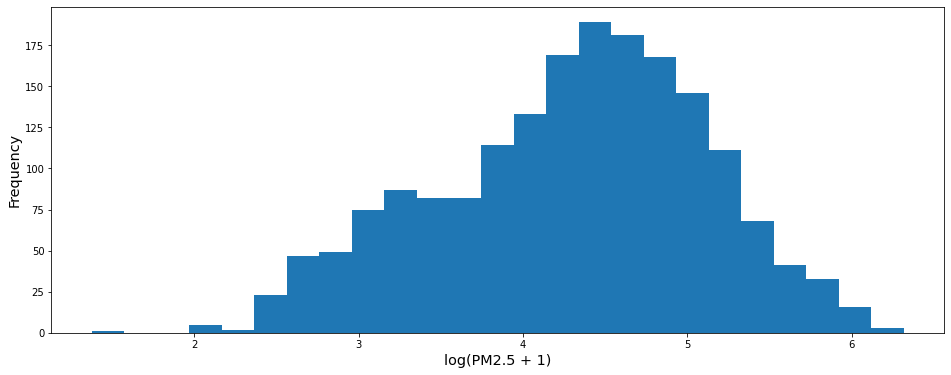

In [13]:
ax = np.log1p(data["pm2.5"]).plot.hist(bins=25)
_ = ax.set_xlabel("log(PM2.5 + 1)")

Now let's also do a quick dive into the categorical wind speed variable.

In [14]:
data.describe(include="string")

,wind_dir
count,1825
unique,4
top,SE
freq,801


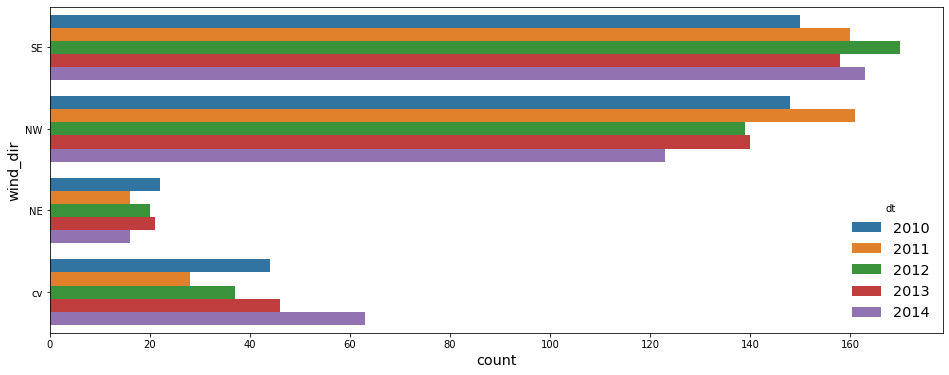

In [15]:
_ = sb.countplot(data=data, y="wind_dir", hue=data.index.year)

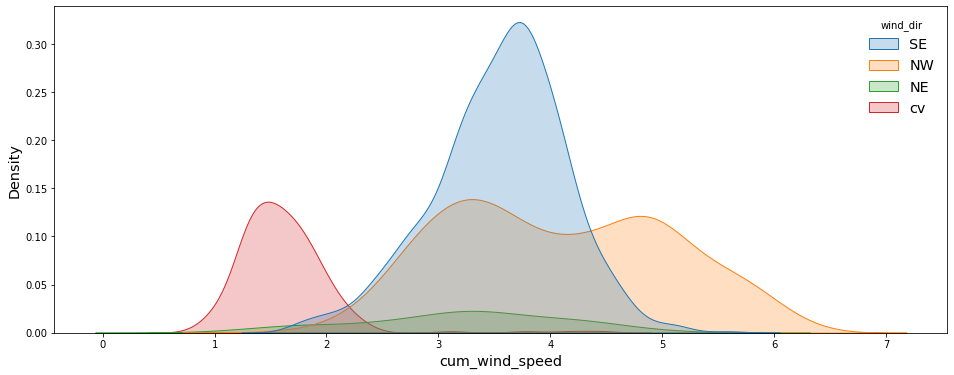

In [16]:
_ = sb.kdeplot(data=data, x=np.log1p(data["cum_wind_speed"].astype(float)), hue="wind_dir", fill=True)

Winds in Beijing blow predominantly in SE and NW directions, with a smaller proportion of NE and "cv" => "calm and variable" days. Changes year-over-year aren't _huge_, but 2014 looks a bit unusual compared to the preceding years. Lastly, as the name suggests, cv days tend to have lower cumulative wind speeds, while SE days tend to have consistently high-ish wind cumulative speeds; NW and NE directions occur over a broader range of speeds.

What about autocorrelation and stationarity?

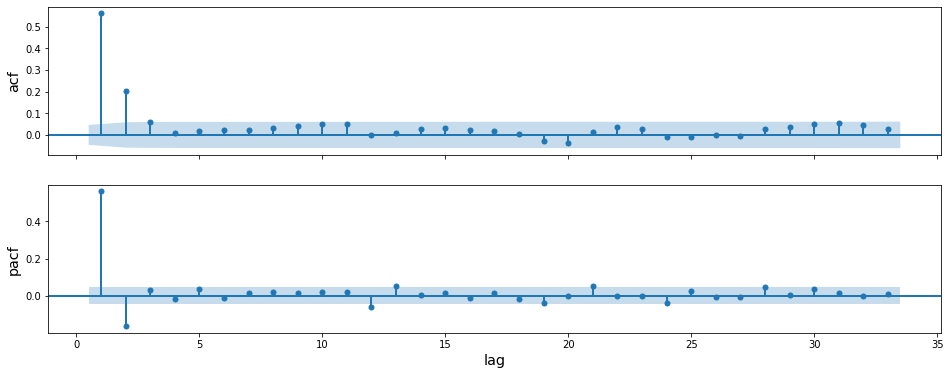

In [17]:
_ = tsf.viz.plot_autocorrelations(data["pm2.5"])

In [18]:
tsf.stats.adfuller_test(data["pm2.5"])

stationarity               True
test statistic       -23.520148
p-value                     0.0
num lags                      1
num obs                    1823
critical value 1%     -3.433942
critical value 5%     -2.863127
critical value 10%    -2.567615
dtype: object

In [19]:
tsf.stats.kpss_test(data["pm2.5"])

/Users/burtondewilde/.pyenv/versions/3.9.1/envs/data-dives/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


stationarity               True
test statistic         0.059109
p-value                     0.1
num lags                     13
critical value 10%        0.347
critical value 5%         0.463
critical value 2.5%       0.574
critical value 1%         0.739
dtype: object

Given the variability in the forecast variable we've seen, it's not surprising that autocorrelation is only significant at small lags. It's also stationary, so no need to apply / model differencing.

Let's also see if there's anything interesting in a season/trend decomposition of PM2.5:

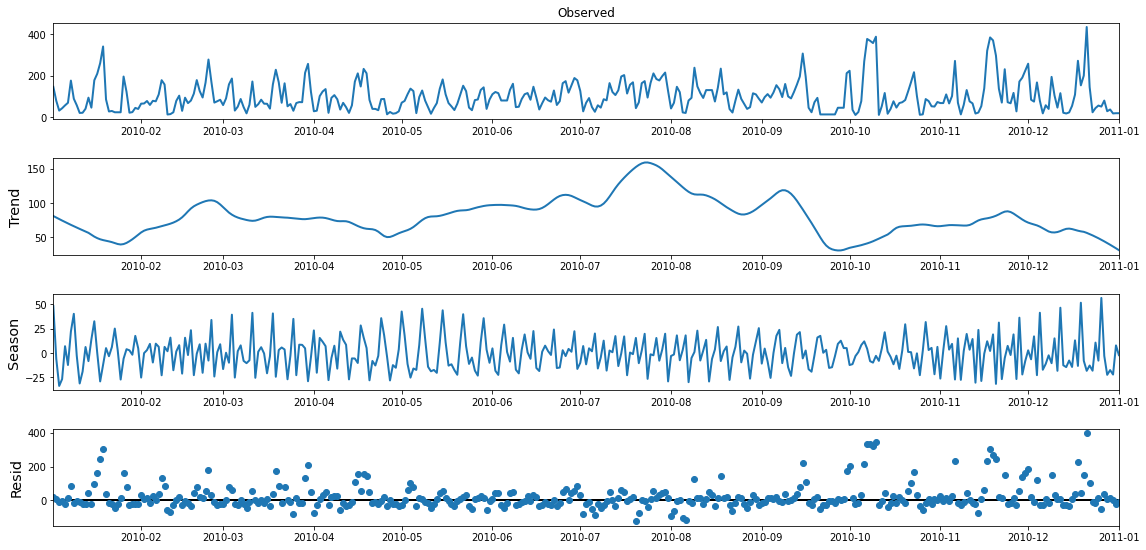

In [20]:
decomp = sm.tsa.STL(data[["pm2.5"]].head(365), seasonal=13, trend=25, robust=True).fit()
fig = decomp.plot()
fig.set_size_inches(16, 8)

Looks like the LOESS smoothing is able to pull out a weekly seasonal component, but it is highly variable over time. Many models require seasonal components to be fixed, in which case weekly seasonality may not be amenable to modeling. Also, if there's an underlying trend component, its slope is definitely changing over time.

## model training and evaluation

### feature engineering

We've not bothered to round up time series data for known causal predictors (fossil fuel energy generation, vehicle traffic, etc.), so instead we'll just attempt to model them off past values of the forecast variable and forecast errors. Many of the weather-related variables are _confounders_, which is fine for forecasting purposes; regardless, we have to massage them a bit. Specifically, let's engineer a few predictor variables:

- one-hot encode categorical wind direction variable
- add a lagged value of cumulative wind speed, since previous days' winds may well affect the current day's air quality
- create a binary variable indicating weekday vs weekend, since we might expect air pollution sources to be reasonably different in these cases and full weekly seasonality appears to be weak
- model annual seasonality (period $m$ = 365.25 days) using the first $k$ terms of a Fourier series rather than seasonal dummy variables, since they're able to deal with long and non-integer periods; mathematically, these features are given by

$$
x_{k, t} = \sin \left( k \cdot \frac{2 \pi t}{m} \right) \;,\;
x_{2k, t} = \cos \left( k \cdot \frac{2 \pi t}{m} \right)
$$

In [21]:
pd.get_dummies(data["wind_dir"], prefix="wind_dir", drop_first=True)

,wind_dir_NW,wind_dir_SE,wind_dir_cv
dt,,,
2010-01-02,0,1,0
2010-01-03,0,1,0
2010-01-04,1,0,0
2010-01-05,1,0,0
2010-01-06,0,0,0
...,...,...,...
2014-12-27,1,0,0
2014-12-28,1,0,0
2014-12-29,0,0,1


In [22]:
data["cum_wind_speed"].shift(periods=1).fillna(0.0)

dt
2010-01-02      0.00
2010-01-03     55.43
2010-01-04    127.84
2010-01-05    198.45
2010-01-06    218.57
               ...  
2014-12-27      4.90
2014-12-28     27.73
2014-12-29     37.98
2014-12-30      8.46
2014-12-31     38.88
Freq: D, Name: cum_wind_speed, Length: 1825, dtype: float64

In [23]:
pd.Series(data=(data.index.weekday >= 5).astype(int), index=data.index, name="is_weekend").to_frame()

,is_weekend
dt,
2010-01-02,1
2010-01-03,1
2010-01-04,0
2010-01-05,0
2010-01-06,0
...,...
2014-12-27,1
2014-12-28,1
2014-12-29,0


In [24]:
# we shouldn't use a deterministic trend here, since we saw above that trend changes over time
# constant = statsmodels.tsa.deterministic.TimeTrend(constant=True, order=0)
annual_seasonal = statsmodels.tsa.deterministic.Fourier(period=365.25, order=2)
dp = statsmodels.tsa.deterministic.DeterministicProcess(
    data.index, additional_terms=[annual_seasonal],  # constant
)
dp.in_sample()

,"sin(1,365.25)","cos(1,365.25)","sin(2,365.25)","cos(2,365.25)"
dt,,,,
2010-01-02,0.000000,1.000000,0.000000,1.000000
2010-01-03,0.017202,0.999852,0.034398,0.999408
2010-01-04,0.034398,0.999408,0.068755,0.997634
2010-01-05,0.051584,0.998669,0.103031,0.994678
2010-01-06,0.068755,0.997634,0.137185,0.990545
...,...,...,...,...
2014-12-27,-0.107308,0.994226,-0.213377,0.976970
2014-12-28,-0.090190,0.995925,-0.179645,0.983732
2014-12-29,-0.073045,0.997329,-0.145700,0.989329


In [25]:
X = pd.concat(
    [
        data[["dew_point", "temp", "pressure", "hrs_snow", "hrs_rain", "cum_wind_speed"]].assign(
            lag_cum_wind_speed=lambda df: df["cum_wind_speed"].shift(periods=1).fillna(0.0)
        ),
        pd.get_dummies(data["wind_dir"], prefix="wind_dir", drop_first=True),
        dp.in_sample().assign(
            is_weekend=lambda df: (df.index.weekday >= 5).astype(int),
        ),
    ],
    axis="columns",
)
y = data["pm2.5"]
X.head()

,dew_point,temp,pressure,hrs_snow,hrs_rain,cum_wind_speed,lag_cum_wind_speed,wind_dir_NW,wind_dir_SE,wind_dir_cv,"sin(1,365.25)","cos(1,365.25)","sin(2,365.25)","cos(2,365.25)",is_weekend
dt,,,,,,,,,,,,,,,
2010-01-02,-8.500000,-5.125000,1024.750000,0.708333,0.0,55.43,0.00,0,1,0,0.000000,1.000000,0.000000,1.000000,1
2010-01-03,-10.125000,-8.541667,1022.791667,14.166667,0.0,127.84,55.43,0,1,0,0.017202,0.999852,0.034398,0.999408,1
2010-01-04,-20.875000,-11.500000,1029.291667,0.000000,0.0,198.45,127.84,1,0,0,0.034398,0.999408,0.068755,0.997634,0
2010-01-05,-24.583333,-14.458333,1033.625000,0.000000,0.0,218.57,198.45,1,0,0,0.051584,0.998669,0.103031,0.994678,0
2010-01-06,-23.708333,-12.541667,1033.750000,0.000000,0.0,59.00,218.57,0,0,0,0.068755,0.997634,0.137185,0.990545,0


### SARIMAX

A dynamic regression model includes information from past observations of the forecast variable _as well as_ exogenous predictor variables that help explain some variation in the forecast variable, including deterministic trend / calendar terms and any other related time series. SARIMAX is such a model; effectively, it's a regression model with SARIMA errors:

$$
y_{t} = \beta_{0} + \beta_{1} x_{1, t} + \cdots + \beta_{k} x_{k, t} + \eta_{t} \\
\left( 1 - \phi_{1}L \right) \eta_{t} = \left( 1 + \theta_{1} L \right) \epsilon_{t}
$$

where $\eta_{t}$ is the error from the regression model and $\epsilon_{t}$ is the error from the SARIMA model distributed as white noise. We do this instead of including the covariates all together in a standard regression model because it makes interpreting variables' coefficients easier.

We saw earlier that the forecast variable is already stationary (so $d$ and $D$ can be set to zero), but most of the exogenous predictor variables have strong annual seasonality and therefore are _not_ stationary; however, for this type of model, all variables must be stationary, otherwise the math gets weird and estimating model coefficients becomes problematic. So, we'll first-difference all predictor variables (even the already stationary ones, for consistency), resuling in a "model in differences". Recall that we're modeling annual seasonality via exogenous Fourier term variables, but let's try modeling weekly seasonality via the SARIMA component.

Let's also use log-transformed values of the forecast variable, since earlier we noted a significant skew.

Since it wasn't obvious from EDA what lags should be used for the seasonal and non-seasonal auto-regressive ($p$, $P$) and moving average ($q$, $Q$) components, let's just do a brute-force search over all possible combinations and pick the model with the lowest AICc. (Note: A smarter version of this process is performed by so-called "auto-ARIMA" packages.)

In [26]:
X_diff = X.diff(periods=1).fillna(0.0)
y_log = np.log1p(y)

In [27]:
import warnings
warnings.simplefilter("ignore")

In [28]:
# strange...
# results = sm.tsa.arma_order_select_ic(np.log1p(y_train), max_ar=14, max_ma=2, ic="aic", fit_kw={"method": "css"})
# results = sm.tsa.arma_order_select_ic(y_train, max_ar=14, max_ma=2, ic="aic", fit_kw={"method": "css"})
# results.aic_min_order

In [29]:
m = 7
ps = [0, 1, 2, 3]
qs = [0, 1]
Ps = [0, 1, 2]
Qs = [0, 1]

aiccs = {}
for p, q, P, Q in itertools.product(ps, qs, Ps, Qs):
    result = (
        sm.tsa.SARIMAX(
            y_log,
            exog=X_diff,
            order=(p, 0, q),
            seasonal_order=(P, 0, Q, m),
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        .fit()
    )
    aiccs[(p, q, P, Q)] = result.aicc

In [30]:
sorted(aiccs.items(), key=lambda x: x[1])[:20]

[((1, 0, 2, 1), 3292.333527905081),
 ((2, 1, 2, 1), 3321.2396748514593),
 ((1, 0, 0, 0), 3461.8265206152105),
 ((2, 1, 1, 1), 3475.076128255547),
 ((2, 1, 0, 1), 3490.9976661311216),
 ((3, 1, 0, 0), 3504.012178529333),
 ((0, 1, 2, 1), 3504.5253931725347),
 ((2, 1, 0, 0), 3506.2265155567793),
 ((1, 1, 0, 0), 3528.514583136538),
 ((1, 1, 0, 1), 3539.492738217387),
 ((3, 1, 0, 1), 3545.115573091268),
 ((0, 1, 1, 1), 3553.0799408681214),
 ((1, 1, 2, 1), 3581.5797045161494),
 ((1, 0, 1, 1), 3592.233426952721),
 ((2, 1, 2, 0), 3598.6967344512286),
 ((1, 0, 0, 1), 3601.1996057490196),
 ((1, 1, 1, 1), 3607.2933009665408),
 ((2, 0, 0, 1), 3630.195075007083),
 ((3, 1, 2, 1), 3634.6865350572425),
 ((2, 0, 0, 0), 3651.5054351944086)]

Based on these results, we can reasonably expect SARIMA(1, 0, 0)x(2, 0, 1, 7) to be the best fitting model for our dataset.

In [31]:
order = (1, 0, 0)
seasonal_order = (2, 0, 1, 7)

In [32]:
model = sm.tsa.SARIMAX(y_log, exog=X_diff, order=order, seasonal_order=seasonal_order)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               pm2.5   No. Observations:                 1825
Model:             SARIMAX(1, 0, 0)x(2, 0, [1], 7)   Log Likelihood               -1746.288
Date:                             Fri, 19 Feb 2021   AIC                           3532.577
Time:                                     16:28:51   BIC                           3642.763
Sample:                                 01-02-2010   HQIC                          3573.223
                                      - 12-31-2014                                         
Covariance Type:                               opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
dew_point              0.0591      0.003     17.863      0.000       0.053       0.066
temp                   0.0125      0.006      2.042      0.041       0.001       0.025
pressure              -0.0326      0.003     -9.619      0.000      -0.039      -0.026
hrs_snow              -0.0200      0.013     -1.517      0.129      -0.046       0.006
hrs_rain               0.0251      0.007      3.425      0.001       0.011       0.039
cum_wind_speed        -0.0004      0.000     -1.938      0.053      -0.001    4.41e-06
lag_cum_wind_speed    -0.0012      0.000     -6.474      0.000      -0.002      -0.001
wind_dir_NW            0.0001      0.000      1.150      0.250   -9.95e-05       0.000
wind_dir_SE            0.0004      0.000      2.741      0.006       0.000       0.001
wind_dir_cv            0.0007      0.000      4.220      0.000       0.000       0.001
sin(1,365.25)         -9.4736      5.010     -1.891      0.059     -19.294       0.347
cos(1,365.25)         -4.1670      4.968     -0.839      0.402     -13.904       5.570
sin(2,365.25)         10.0439      1.919      5.234      0.000       6.283      13.805
cos(2,365.25)          0.0601      1.910      0.031      0.975      -3.683       3.803
is_weekend             0.1309      0.098      1.335      0.182      -0.061       0.323
ar.L1                  0.7019      0.017     42.022      0.000       0.669       0.735
ar.S.L7                0.7981      0.029     27.846      0.000       0.742       0.854
ar.S.L14               0.1788      0.027      6.531      0.000       0.125       0.233
ma.S.L7               -0.8724      0.016    -53.418      0.000      -0.904      -0.840
sigma2                 0.3851      0.014     27.887      0.000       0.358       0.412
===================================================================================
Ljung-Box (L1) (Q):                   8.69   Jarque-Bera (JB):                47.61
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                            -0.29
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

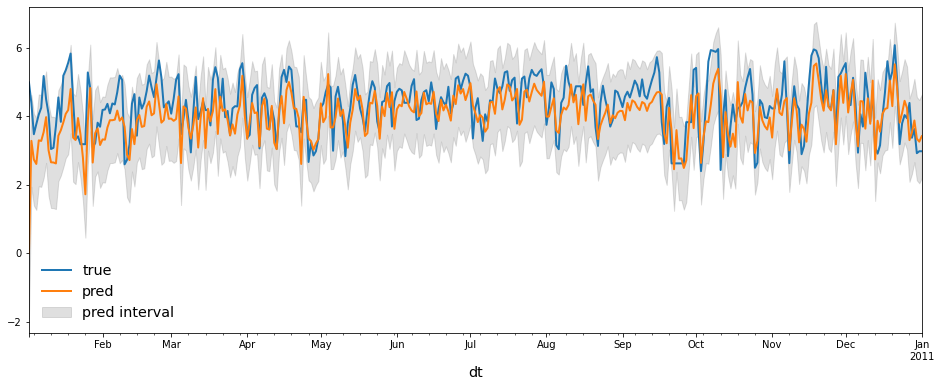

In [33]:
preds = result.get_prediction(dynamic=False).summary_frame(alpha=0.05)

ax = tsf.viz.plot_time_series(
    [y_log.head(365), preds["mean"].head(365)],
    labels=["true", "pred"],
    subplots=False,
)
ax.fill_between(
    preds.head(365).index,
    preds["mean_ci_upper"].head(365),
    preds["mean_ci_lower"].head(365),
    color="gray",
    alpha=0.25,
    label="pred interval"
)
_ = ax.legend()

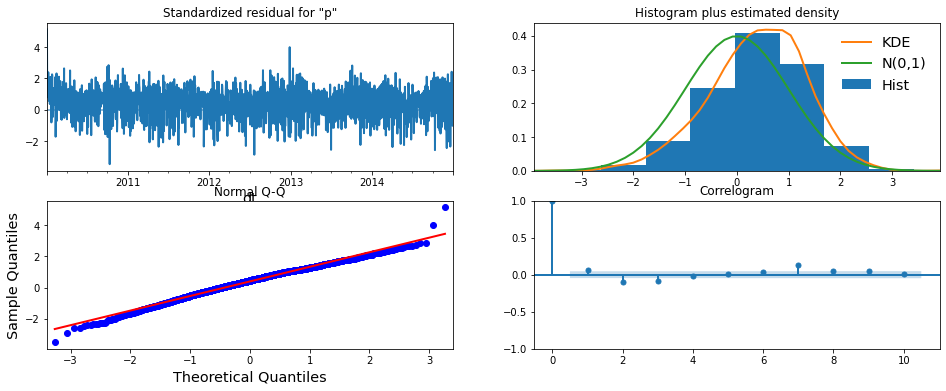

In [34]:
_ = result.plot_diagnostics()

Not perfect, but not bad: residuals have minimal autocorrelation, and they're close to normally distributed, buut the mean isn't right at 0. How's our out-of-sample performance?

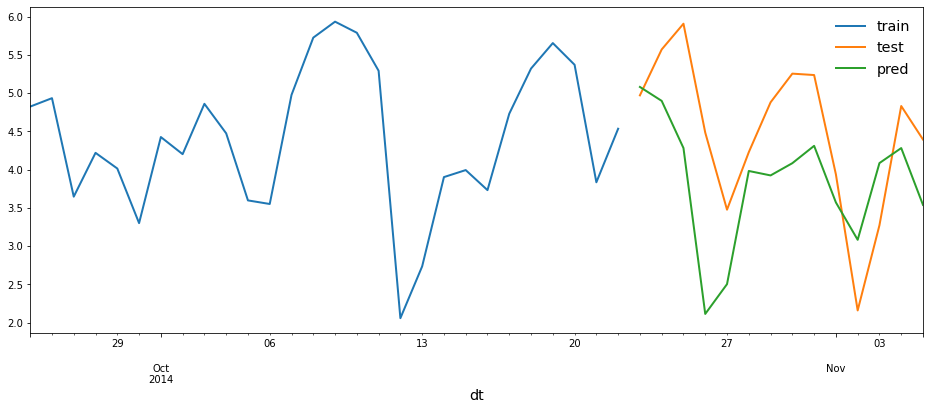

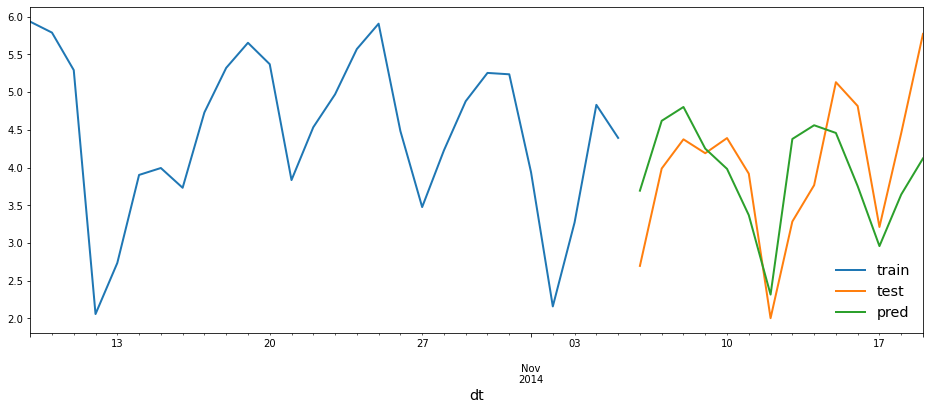

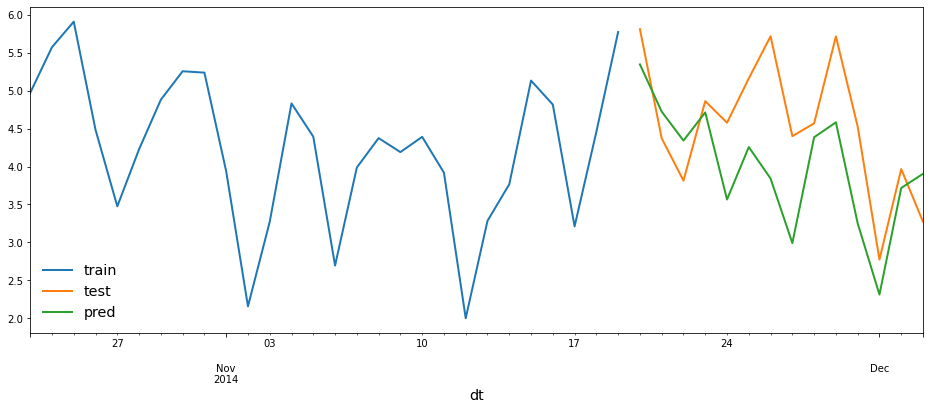

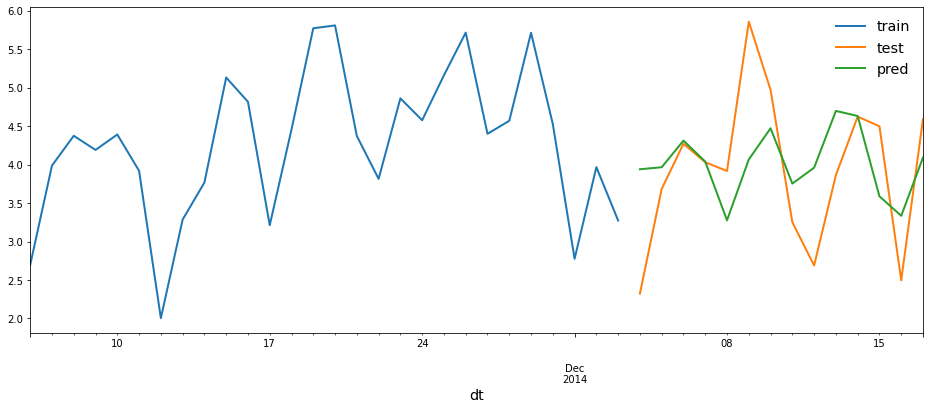

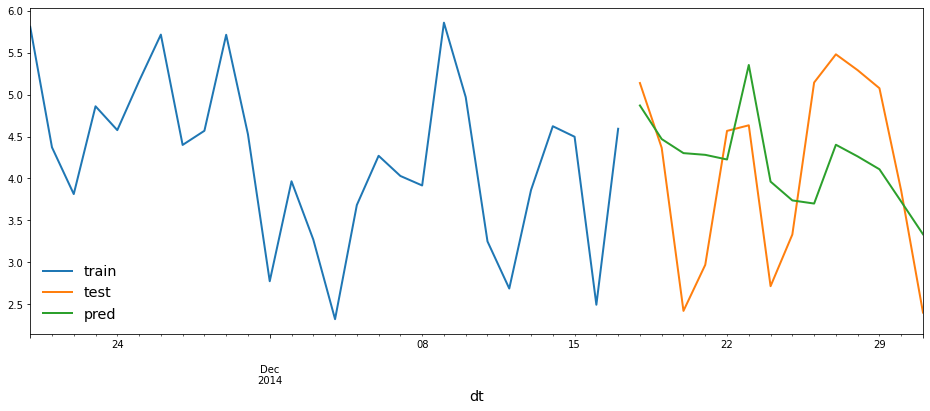

In [35]:
cv_scores = []
data_splits = (
    sklearn.model_selection.TimeSeriesSplit(n_splits=5, gap=0, max_train_size=7*52*2, test_size=7*2)
    .split(y_log)
)
for train_idxs, test_idxs in data_splits:
    X_train = X_diff.iloc[train_idxs, :]
    X_test = X_diff.iloc[test_idxs, :]
    y_train = y_log.iloc[train_idxs]
    y_test = y_log.iloc[test_idxs]
    
    model = sm.tsa.SARIMAX(y_train, exog=X_train, order=order, seasonal_order=seasonal_order)
    result = model.fit()
    yhat_test = result.predict(
        start=y_test.index.min().date(),
        end=y_test.index.max().date(),
        exog=X_test,
    )
    
    cv_scores.append(
        {
            "MAE": sklearn.metrics.mean_absolute_error(np.log1p(y_test), yhat_test),
            "MSE": sklearn.metrics.mean_squared_error(np.log1p(y_test), yhat_test, squared=True),
            "R^2": sklearn.metrics.r2_score(np.log1p(y_test), yhat_test),
        }
    )
    ax = tsf.viz.plot_time_series(
        [y_train.tail(7*4), y_test, yhat_test],
        labels=["train", "test", "pred"],
        subplots=False,
    )

cv_scores = pd.DataFrame(cv_scores)

In [36]:
cv_scores

,MAE,MSE,R^2
0,2.156812,5.159954,-130.170283
1,2.331987,5.762914,-138.694845
2,2.296371,5.732456,-212.371268
3,2.432422,6.061928,-147.121221
4,2.591237,6.914659,-132.087606


In [37]:
cv_scores.mean()

MAE      2.361766
MSE      5.926382
R^2   -152.089045
dtype: float64

If we squint, we can see how the 14-day out-of-sample predictions (i.e. _forecasts_) for each data split at least somewhat resemble the true values. But they're probably not good enough for citizens of Beijing to use when making decisions about, say, going out for the day with or without a face mask.

So. What else might we try to improve our forecasts?

### bootstrapping and bagging

We can generate additional training data using a process called "bootstrapping", which typically entails random sampling of an original dataset with replacement to produce a new but similar dataset. Since the order of observations in time series data is important, we instead use a "blocked" bootstrap in which blocks of contiguous values (rather than individual values) are randomly selected and concatenated together. There are a few different strategies for generating such blocks, but two common ones are

- **moving block:** Bootstrap using blocks of a fixed length with random starting points, without looping over the boundaries of the series. Note that this systematically undersamples near the edges of the series.
- **circular block:** Bootstrap using blocks of a fixed length with random starting points, wrapping end-to-start over the boundaries of the series for blocks that start close to the end. Note that this only makes sense if the series is stationary.

In our case, we'll decompose the forecast variable into trend, seasonal, and residual components, get bootstrapped samples of the residuals, then add them back to the other components.

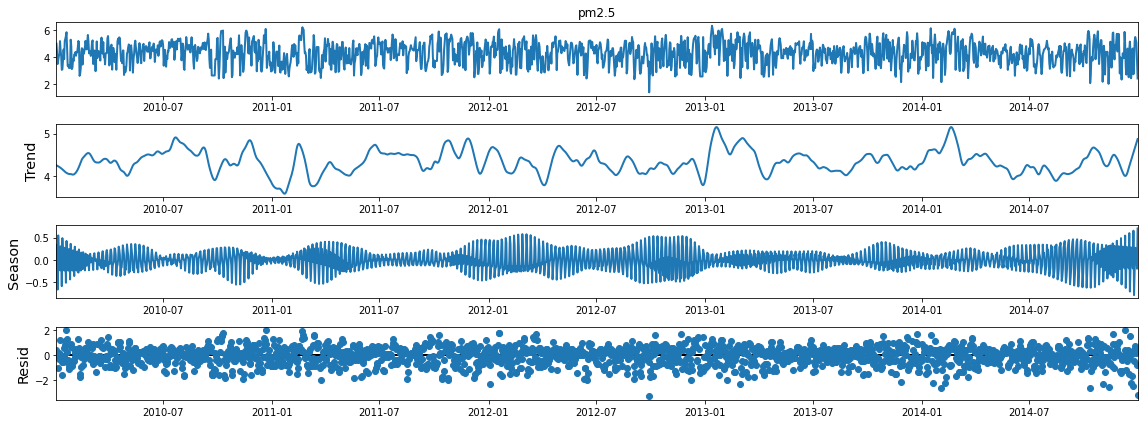

In [38]:
decomp = sm.tsa.STL(y_log, seasonal=21, trend=35, robust=True).fit()
_ = decomp.plot()

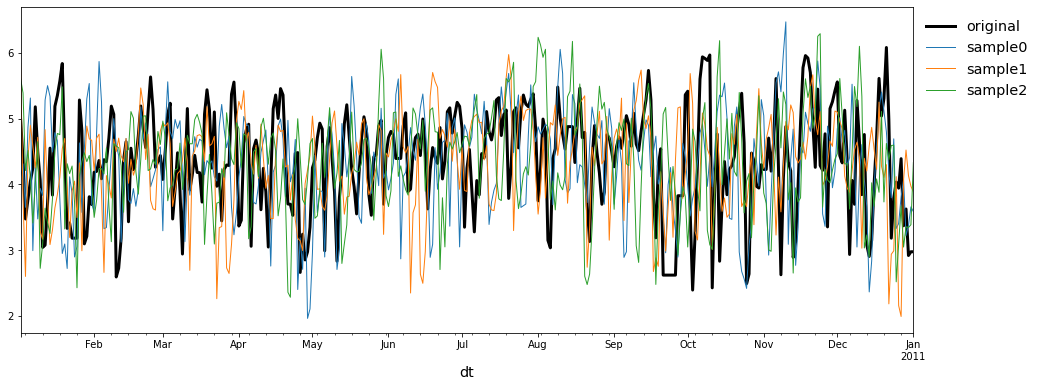

In [39]:
n_samples = 3
block_size = 120
bootstrapped_residuals = [
    tsf.bootstrapping.bootstrap(decomp.resid, block_size=block_size, strategy="mb")
    for i in range(n_samples)
]
bootstrapped_ys = [
    decomp.trend + decomp.seasonal + bresid
    for bresid in bootstrapped_residuals
]

ax = y_log.head(365).plot.line(color="black", lw=3, label="original")
for i, bsy in enumerate(bootstrapped_ys):
    bsy.head(365).plot.line(ax=ax, lw=1, label=f"sample{i}")
_ = ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

Nice! We can see that the resampled time series are not the same, but they look broadly similar.

Now, we'll use the bootstrapped time series to train multiple models and average their forecasts together, resulting in an improved single forecast. This form of ensembling is called "bagging", which stands for "bootstrap aggregating". Although we could tweak model hyperparameters to suit each bootstrapped sample, there's no compelling reason to bother — all of these time series should be roughly similar, so the same model ought to apply. The estimated parameters of each will be different, of course, resulting in slightly different forecasts.

In [40]:
test_split = "2014-12-01"
X_train = X_diff.loc[X_diff.index < test_split, :]
X_test = X_diff.loc[X_diff.index >= test_split, :]
y_train = y_log.loc[y_log.index < test_split]
y_test = y_log.loc[y_log.index >= test_split]
models = []
# original model trained on original data
models.append(
    sm.tsa.SARIMAX(y_train, exog=X_train, order=order, seasonal_order=seasonal_order).fit()
)
# bootstrapped models trained on bootstrapped data
decomp = sm.tsa.STL(y_train, seasonal=21, trend=35, robust=True).fit()
for i in range(5):
    bs_resid, bs_X_train = tsf.bootstrapping.bootstrap(decomp.resid, X_train, block_size=90, strategy="cb")
    bs_y_train = decomp.trend + decomp.seasonal + bs_resid
    models.append(
        sm.tsa.SARIMAX(bs_y_train, exog=bs_X_train, order=order, seasonal_order=seasonal_order).fit()
    )
models

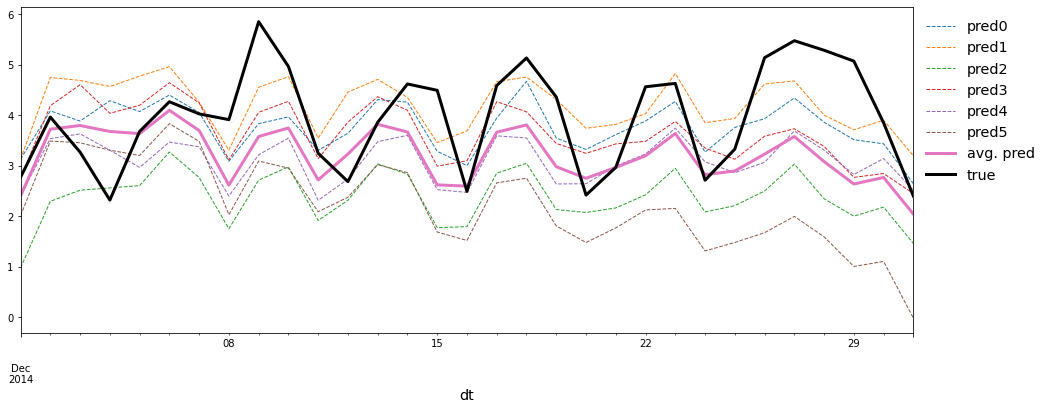

In [41]:
models_preds = [
    model.predict(start=X_test.index.min(), end=X_test.index.max(), exog=X_test, dynamic=True)
    for model in models
]
avg_model_pred = pd.concat(models_preds, axis="columns").mean(axis="columns")
ax = tsf.viz.plot_time_series(
    models_preds,
    [f"pred{i}" for i in range(len(models))],
    subplots=False,
    plot_kw={"ls": "dashed", "lw": 1},
)
_ = avg_model_pred.plot.line(ax=ax, lw=3, label="avg. pred")
_ = y_test.plot.line(ax=ax, color="black", lw=3, label="true")
_ = ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

We can see that the "bagged" forecast is a bit more reliable than any of the individual models' forecasts, but clearly there's room for improvement in producing reliable short-term forecasts of PM2.5 levels.

There are several other things we could try: fitting different / more sophisticated models, adding / improving the exogenous predictor features, combining forecasts from different models (which is similar in spirit but different in form from the bagging performed above), smoothing or otherwise transforming the forecast variable, and more. But for the purposes of this tutorial, let's call it here.

## references

As inspiration and reference, I relied on an excellent online textbook:

Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia. https://otexts.com/fpp3. 